# Using GPs.jl

In [1]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

In [2]:
include("../src/GP.jl")
using .GPs

In [3]:
f = GP(rbf([1.], [1.]))
ϵ = GP(noise([0.2]))
y = f + ϵ;

In [4]:
Xs = 0:0.01:10;

### Prior

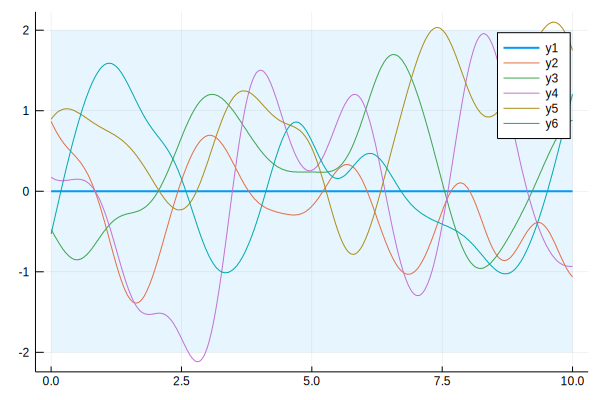

In [5]:
plot(Xs, f(Xs))
plot!(Xs, rand(f(Xs), 5))

### Posterior
First generate some evidence, then get a pretty posterior formulation.

In [6]:
_y = GPs.GP(GPs.constant_mean(-1.), GPs.rbf([0.5], [2])) + GPs.GP(GPs.noise([0.5]))
n = 10
X̂ = rand(n).*8 .+ 1
ŷ = rand(_y(X̂))
[X̂ ŷ]

10×2 Array{Float64,2}:
 5.29135   0.555389
 8.65052  -1.86947
 4.64247   1.89542
 8.88773  -2.76828
 4.59779   1.26823
 7.91228  -0.550772
 3.60808  -3.47448
 1.72701  -5.78202
 6.705     0.822656
 7.18178   0.502706

In [7]:
struct Evidence
    gp::GP
    X::Array
    y::Array
end
←(gp::GP, obs::Tuple{Array, Array}) = Evidence(gp, obs[1], obs[2])
function |(gp::GP, evidence::Evidence)
    y = evidence.gp
    X̂, ŷ = evidence.X, evidence.y
    Δy = ŷ - gp.μ(X̂)
    K_inv = inv(Symmetric(y.k(X̂, X̂) + 1e-6*I))
    
    μ(x) = gp.μ(x) .+ gp.k(x, X̂) * K_inv * Δy
    k(x₁, x₂) = gp.k(x₁, x₂) - gp.k(x₁, X̂) * K_inv * gp.k(X̂, x₂)
    
    return GPs.GP(μ, k)
end

| (generic function with 1 method)

In [8]:
f′ = f | (y ← (X̂, ŷ))

GP(var"#μ#3"{GP,Array{Float64,1},Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(Main.GPs.var"#1#2"(), Main.GPs.var"#5#6"{Array{Float64,1},Array{Float64,1}}([1.0], [1.0])), [5.291352684519696, 8.650518948824134, 4.642472580054392, 8.887729897563394, 4.59779370847262, 7.9122754257696215, 3.608076019393282, 1.7270069736401936, 6.705001205872454, 7.181775004641461], [0.5553888723759934, -1.869472089757834, 1.8954198999111953, -2.768281699122505, 1.2682310503883847, -0.5507718236155245, -3.4744757990401474, -5.782017932984317, 0.8226559017132555, 0.502705821921055], [1.756779856052383 0.09612699166947918 … -0.501962622442565 0.4240816817165278; 0.09612699166947918 9.048301526112441 … -0.8243696162914669 1.829911786807969; … ; -0.501962622442565 -0.8243696162914669 … 3.0156624036646766 -2.9654055225748635; 0.4240816817165278 1.829911786807969 … -2.9654055225748635 4.507838417718272]), var"#k#4"{GP,Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(Main.GPs.var"#1#2"(), Main.G

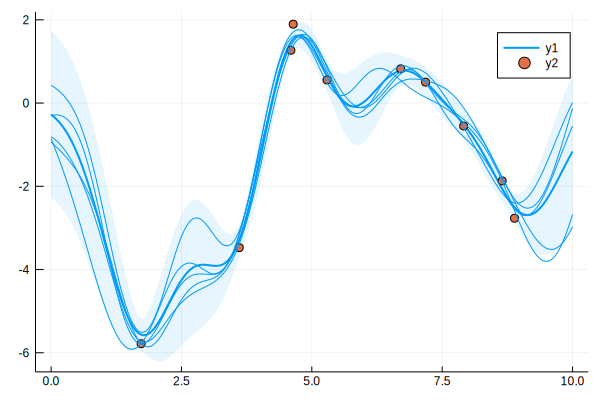

In [9]:
plot(Xs, f′(Xs))
scatter!(X̂, ŷ, color=2)
plot!(Xs, rand(f′(Xs), 5), color=1, label="")